In [2]:
from PIL import Image
import pandas as pd
from dateutil import parser
%matplotlib inline
import pytz
import numpy as np

In [3]:
DIR = "/Users/damoncrockett/Desktop/"

### File ops

In [ ]:
df = pd.read_csv(DIR+"London.csv")

In [ ]:
df.postedTime = df.postedTime.apply(parser.parse)

In [ ]:
df['year'] = [item.year for item in df.postedTime]

In [ ]:
df = df[df.year==2012]

In [ ]:
df['month'] = [item.month for item in df.postedTime]

In [ ]:
df = df[df.month==11]

In [ ]:
df['day'] = [item.day for item in df.postedTime]

In [ ]:
df = df[df.day <= 10]
df = df[df.day >= 4]

In [ ]:
import datetime

In [ ]:
zero = datetime.datetime(2012, 11, 4, 0, 0, 0, 0, pytz.UTC)

In [ ]:
df['secpast'] = [int((item-zero)/datetime.timedelta(seconds=1)) for item in df.postedTime]

In [ ]:
df.sort_values(by='secpast',inplace=True)

In [ ]:
df.to_csv(DIR+"london_2012_nov.csv",index=False)

### Optional read-in

In [32]:
d = pd.read_csv(DIR+"firstlook/london_2012_nov.csv")

In [33]:
d.basename = [item[:-4] for item in d.basename]

In [34]:
d.set_index("basename",inplace=True)

In [35]:
df = pd.read_csv(DIR+"firstlook/slices/slice_metadata.csv")

In [36]:
df['basename'] = [item.split("/")[6] for item in df.filename]

In [37]:
df = df.join(d[['secpast']],on="basename")

In [38]:
df = df[df.val_mean.notnull()]

In [39]:
df.reset_index(drop=True,inplace=True)

In [40]:
len(df)

4369604

In [41]:
df = df.sample(n=436960)

### Plot

In [42]:
thumb_side = 8
sort_vars = ['val_mean']

In [43]:
#im = Image.new('RGBA',(thumb_side,thumb_side),'hsl(180,0%,100%)') # important that it has alpha channel

In [44]:
def cratio(nbins):
    df['xbin'] = pd.cut(df.secpast,nbins,labels=False)
    bin_max = df.groupby('xbin').size().max()
    diff = 2*np.pi - float(nbins)/bin_max
    return diff

In [45]:
import matplotlib.pyplot as plt

In [74]:
nbins = range(4120,4140)
cratios = [cratio(item) for item in nbins]

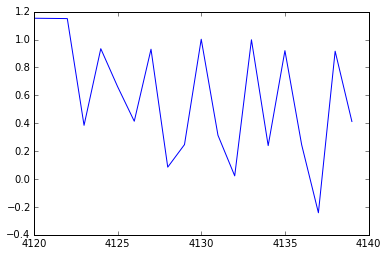

In [75]:
fig,ax = plt.subplots()
ax.plot(nbins,cratios)

In [76]:
diffs = [abs(item) for item in cratios]
mindiff = diffs.index(min(diffs))
nbins = nbins[mindiff] # this setting makes it so that the circumference and radius are appropriate

In [77]:
df['xbin'] = pd.cut(df.secpast,nbins,labels=False)
bin_max = df.groupby('xbin').size().max()

In [78]:
px_w = (bin_max * 2 * thumb_side) + thumb_side
px_h = px_w

In [79]:
print px_w, px_h

10568 10568


In [80]:
canvas = Image.new('RGB',(px_w,px_h),'hsl(180,0%,50%)')

In [81]:
def pol2cart(rho, phi):
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return(x, y)

In [82]:
def bin2phi(binn):
    incr = float(360)/nbins
    return np.radians(incr*binn)

In [83]:
def bin2phideg(binn):
    incr = float(360)/nbins
    return incr*binn

In [84]:
bins = list(set(list(df.xbin)))

In [85]:
bins.sort()

In [86]:
for item in bins:
    if np.random.binomial(1,.001)==1:
        print item
    
    tmp = df[df.xbin==item]
    tmp.sort_values(by="val_mean",inplace=True,ascending=False)
    tmp.reset_index(drop=True,inplace=True)

    for i in range(len(tmp)):
        im = Image.open(tmp.filename.loc[i])
        im = im.convert('RGBA')
        im.thumbnail((thumb_side,thumb_side),Image.ANTIALIAS)
        pos = bin_max - i
        xy = pol2cart(pos,bin2phi(item))
        phi = bin2phideg(item)
        im = im.rotate(phi,expand=1)
        
        xcoord = int(round((xy[0] + bin_max) * thumb_side))
        ycoord = int(round((bin_max - xy[1]) * thumb_side)) #bc high in the image is low y
        canvas.paste(im,(xcoord,ycoord),im) # tmp treated as a mask for itself

/Library/Python/2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


354
1073


In [87]:
canvas.save(DIR+"firstlook.png")